In [115]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [116]:
df = pd.read_csv('insurance.csv')

df.head()





,index,age,sex,bmi,children,smoker,region,charges
0,0,19,female,27.900,0,yes,southwest,16884.92400
1,1,18,male,33.770,1,no,southeast,1725.55230
2,2,28,male,33.000,3,no,southeast,4449.46200
3,3,33,male,22.705,0,no,northwest,21984.47061
4,4,32,male,28.880,0,no,northwest,3866.85520


In [117]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   index     1338 non-null   int64  
 1   age       1338 non-null   int64  
 2   sex       1338 non-null   object 
 3   bmi       1338 non-null   float64
 4   children  1338 non-null   int64  
 5   smoker    1338 non-null   object 
 6   region    1338 non-null   object 
 7   charges   1338 non-null   float64
dtypes: float64(2), int64(3), object(3)
memory usage: 83.8+ KB


In [118]:
df.drop("index", axis=1, inplace=True)

In [119]:
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [120]:
df["region"].value_counts()

region
southeast    364
southwest    325
northwest    325
northeast    324
Name: count, dtype: int64

<Axes: xlabel='age', ylabel='charges'>

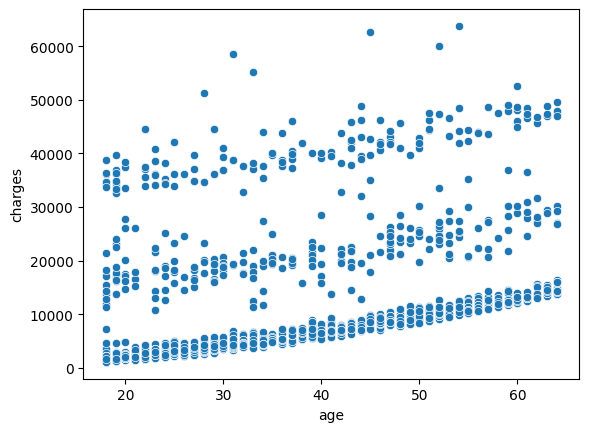

In [121]:
sns.scatterplot(x="age",y="charges",data=df)

<Axes: xlabel='smoker', ylabel='charges'>

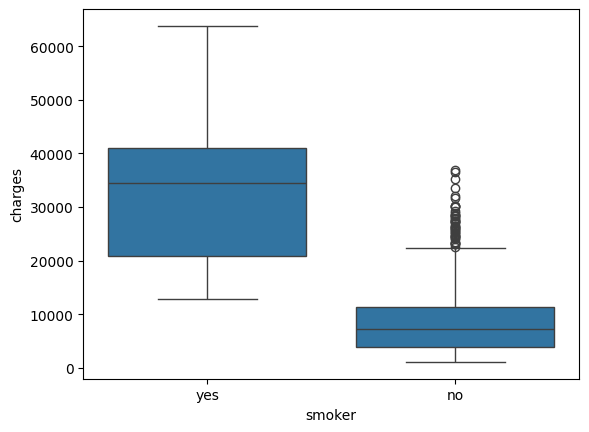

In [122]:
sns.boxplot(x='smoker', y='charges', data=df)

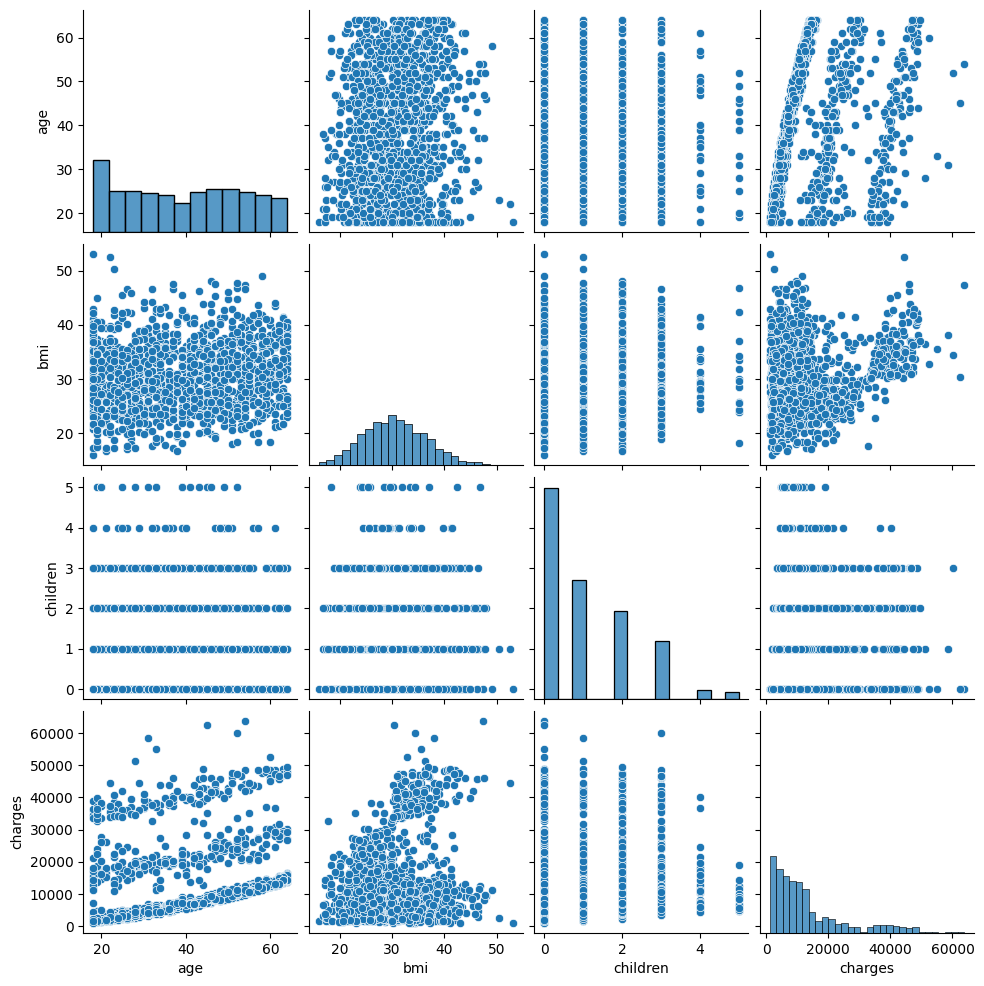

In [123]:
sns.pairplot(df)

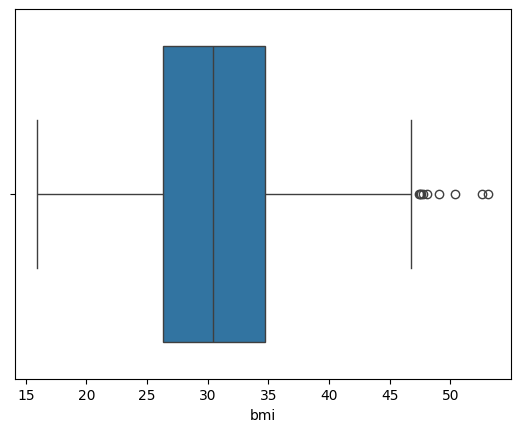

In [124]:
sns.boxplot(x=df['bmi'])
plt.show()

In [125]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [126]:
X = df.drop("charges", axis=1)
y = df["charges"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



In [127]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline







In [128]:
preprocessor = ColumnTransformer(
    transformers=[
        ("1",OneHotEncoder(handle_unknown="ignore"),["sex","smoker","region"]),
        ("2",StandardScaler(),["age","bmi","children"])
    ],
    remainder="passthrough"
)







In [129]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import lightgbm as lgb
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV




In [ ]:
pipelines = {
    "linearreg": Pipeline([
        ("preprocessor",preprocessor)
        ("linearreg",LinearRegression())
    ]),
    "rf": Pipeline([
        ("preprocessor",preprocessor),
        ("rf",RandomForestRegressor(n_estimators=100,random_state=42))
    ]),
    "xgb": Pipeline([
        ("preprocessor",preprocessor),
        ("xgb",xgb.XGBRegressor(n_estimators=100,random_state=42))
    ]),
    "lgbm":Pipeline([
        ("preprocessor",preprocessor),
        ("lgbm",lgb.LGBMRegressor(n_estimators=100,random_state=42))
    ])    
}







In [131]:
for name,pipeline in pipelines.items():
    pipeline.fit(X_train,y_train)
    y_pred = pipeline.predict(X_test)
    print(f"{name} modeli için:")
    mse = mean_squared_error(y_test,y_pred)
    r2 = r2_score(y_test,y_pred)
    print(f"MSE: {mse:.4f}")
    print(f"R2: {r2:.4f}")
    print("-------------------")
    print("\n")
    
    
    
    
    
    

linearreg modeli için:
MSE: 33596915.8514
R2: 0.7836
-------------------


rf modeli için:
MSE: 21152312.0752
R2: 0.8638
-------------------


xgb modeli için:
MSE: 23522459.7375
R2: 0.8485
-------------------


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000371 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 326
[LightGBM] [Info] Number of data points in the train set: 1070, number of used features: 11
[LightGBM] [Info] Start training from score 13346.089733
lgbm modeli için:
MSE: 21174872.3580
R2: 0.8636
-------------------




/Users/yagiz/Desktop/InsuranceML/venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


In [132]:
from scipy.stats import randint, uniform
import joblib

In [ ]:
import warnings
warnings.filterwarnings('ignore')
lgbm_pipeline = pipelines["lgbm"]

param_dist = {
    
    'lgbm__n_estimators': randint(100, 1000), 
    'lgbm__learning_rate': uniform(0.01, 0.1), 
    'lgbm__num_leaves': randint(20, 50),      
    'lgbm__max_depth': [5, 10, 15, -1],
    'lgbm__min_child_samples': randint(10, 50),
    'lgbm__subsample': uniform(0.7, 0.3),
    'lgbm__colsample_bytree': uniform(0.7, 0.3),
    'lgbm__verbose': [-1] 
}


random_search = RandomizedSearchCV(
    estimator=lgbm_pipeline,
    param_distributions=param_dist,
    n_iter=20,             
    cv=3,                   
    scoring='neg_mean_squared_error', 
    n_jobs=-1,
    verbose=1,
    random_state=42,
    error_score='raise'     
)


try:
    
    if np.any(np.isnan(y_train)):
        print("UYARI: y_train içinde NaN değerler var! Önce bunları temizle.")
    else:
        random_search.fit(X_train, y_train)
        print(f"\nEn İyi Skor (MSE): {random_search.best_score_:.4f}")
        print("En İyi Parametreler:", random_search.best_params_)
        
except Exception as e:
    print("Bir hata oluştu:", e)

Optimizasyon başlıyor...
Fitting 3 folds for each of 20 candidates, totalling 60 fits

En İyi Skor (MSE): -21897019.3850
En İyi Parametreler: {'lgbm__colsample_bytree': np.float64(0.8351497755908628), 'lgbm__learning_rate': np.float64(0.011326496115986653), 'lgbm__max_depth': 5, 'lgbm__min_child_samples': 23, 'lgbm__n_estimators': 341, 'lgbm__num_leaves': 45, 'lgbm__subsample': np.float64(0.7913841307520112), 'lgbm__verbose': -1}


In [ ]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

final_model = random_search.best_estimator_


y_pred_final = final_model.predict(X_test)

r2 = r2_score(y_test, y_pred_final)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_final))
mae = mean_absolute_error(y_test, y_pred_final)

print(f"R2 Skoru (Başarı Yüzdesi): %{r2 * 100:.2f}") 
print(f"RMSE (Ortalama Sapma - Karesel): {rmse:.2f}")
print(f"MAE (Ortalama Sapma - Net): {mae:.2f}")


--- FİNAL MODEL SONUÇLARI ---
R2 Skoru (Başarı Yüzdesi): %87.58
RMSE (Ortalama Sapma - Karesel): 4390.76
MAE (Ortalama Sapma - Net): 2484.31


In [139]:
joblib.dump(final_model, 'final_model.pkl')

['final_model.pkl']